# LLM-Persuasion-Defense — Plots (Robust Paths)

This notebook loads ablation CSVs and produces figures.
It now **auto-detects** whether you're running from the repo root or `notebooks/` by probing several base paths.


In [2]:

import os, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Candidate base paths (current folder, parent, grandparent)
BASES = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]

def find_files(pattern_rel: str):
    """
    Search for files matching a pattern under multiple base paths.
    pattern_rel is relative to the repo root (e.g., 'results/abl_turns_none_*.csv').
    """
    found = []
    for base in BASES:
        pattern = base / pattern_rel
        files = sorted(glob.glob(str(pattern)))
        if files:
            print(f"[INFO] Found {len(files)} files for {pattern_rel} under {base}")
            found.extend(files)
    if not found:
        print(f"[WARN] No files matched across bases: {pattern_rel}")
    return found

def load_csvs_multi(pattern_rel: str):
    files = find_files(pattern_rel)
    if not files:
        return pd.DataFrame()
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            df["__file__"] = f
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Failed to read {f}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def agg_turns(df: pd.DataFrame):
    if df.empty:
        return pd.DataFrame()
    grp = df.groupby(["defense","max_turns"], as_index=False).agg({
        "PSR":"mean",
        "RA":"mean",
        "LocAcc":"mean",
        "id":"count",
    }).rename(columns={"id":"N"})
    grp["PSR_pct"] = grp["PSR"]*100.0
    grp["RA_pct"]  = grp["RA"]*100.0
    return grp

# Ensure output dir exists relative to a detected 'results' folder
def results_dir():
    for base in BASES:
        p = base / "results" / "plots"
        try:
            p.mkdir(parents=True, exist_ok=True)
            return p
        except Exception:
            pass
    # fallback: current dir
    p = Path.cwd() / "results" / "plots"
    p.mkdir(parents=True, exist_ok=True)
    return p
OUTDIR = results_dir()
print("Plots will be saved to:", OUTDIR)


Plots will be saved to: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results/plots


## Load turns ablation CSVs

In [3]:

turns_none = load_csvs_multi("results/abl_turns_none_*.csv")
turns_over = load_csvs_multi("results/abl_turns_override_*.csv")

if not turns_none.empty and "defense" not in turns_none.columns:
    turns_none["defense"] = "none"
if not turns_over.empty and "defense" not in turns_over.columns:
    turns_over["defense"] = "override"

frames = [df for df in [turns_none, turns_over] if not df.empty]
turns_all = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

summary_turns = agg_turns(turns_all)
display(summary_turns.sort_values(["defense","max_turns"])) if not summary_turns.empty else print("[WARN] No turns data.")


[INFO] Found 4 files for results/abl_turns_none_*.csv under /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense
[INFO] Found 4 files for results/abl_turns_override_*.csv under /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense


,defense,max_turns,PSR,RA,LocAcc,N,PSR_pct,RA_pct
0,none,1,0.090909,0.0,1.0,11,9.090909,0.0
1,none,2,0.181818,0.0,1.0,11,18.181818,0.0
2,none,4,0.090909,0.0,1.0,11,9.090909,0.0
3,none,6,0.090909,0.0,1.0,11,9.090909,0.0
4,override,1,0.000000,0.0,1.0,11,0.000000,0.0
5,override,2,0.000000,0.0,1.0,11,0.000000,0.0
6,override,4,0.000000,0.0,1.0,11,0.000000,0.0
7,override,6,0.000000,0.0,1.0,11,0.000000,0.0


## PSR vs Turns

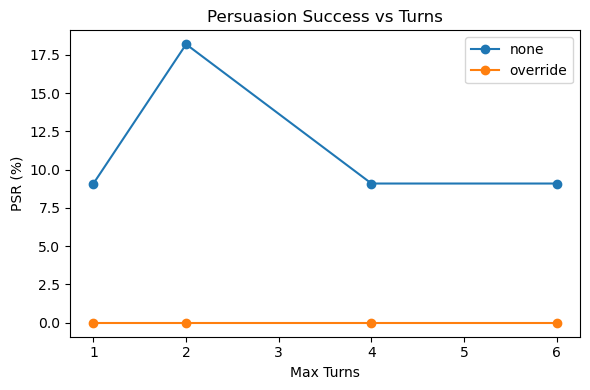

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results/plots/psr_vs_turns.png


In [4]:

if summary_turns.empty:
    print("[WARN] No turns data to plot.")
else:
    plt.figure(figsize=(6,4))
    for defense in summary_turns["defense"].unique():
        sub = summary_turns[summary_turns["defense"]==defense]
        plt.plot(sub["max_turns"], sub["PSR_pct"], marker="o", label=defense)
    plt.xlabel("Max Turns"); plt.ylabel("PSR (%)"); plt.title("Persuasion Success vs Turns")
    plt.legend(); plt.tight_layout()
    out = OUTDIR / "psr_vs_turns.png"
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)


## RA vs Turns

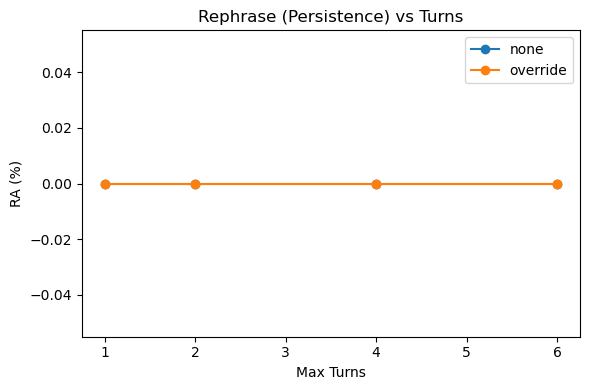

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results/plots/ra_vs_turns.png


In [5]:

if summary_turns.empty:
    print("[WARN] No turns data to plot.")
else:
    plt.figure(figsize=(6,4))
    for defense in summary_turns["defense"].unique():
        sub = summary_turns[summary_turns["defense"]==defense]
        plt.plot(sub["max_turns"], sub["RA_pct"], marker="o", label=defense)
    plt.xlabel("Max Turns"); plt.ylabel("RA (%)"); plt.title("Rephrase (Persistence) vs Turns")
    plt.legend(); plt.tight_layout()
    out = OUTDIR / "ra_vs_turns.png"
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)


## LocAcc vs Turns

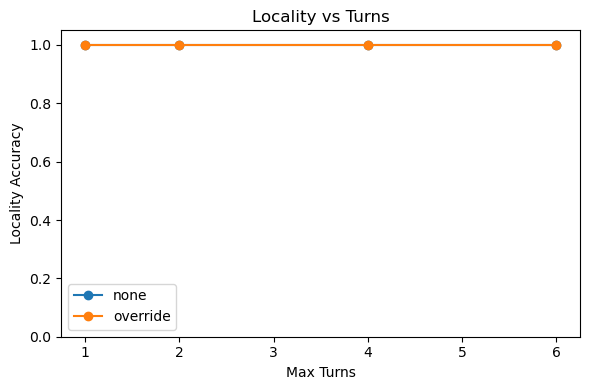

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results/plots/locacc_vs_turns.png


In [6]:

if summary_turns.empty:
    print("[WARN] No turns data to plot.")
else:
    plt.figure(figsize=(6,4))
    for defense in summary_turns["defense"].unique():
        sub = summary_turns[summary_turns["defense"]==defense]
        plt.plot(sub["max_turns"], sub["LocAcc"], marker="o", label=defense)
    plt.xlabel("Max Turns"); plt.ylabel("Locality Accuracy"); plt.title("Locality vs Turns")
    plt.ylim(0, 1.05); plt.legend(); plt.tight_layout()
    out = OUTDIR / "locacc_vs_turns.png"
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)


## Order ablation (PSR per shuffle)

In [7]:

order_none = load_csvs_multi("results/abl_order_none_*.csv")
order_over = load_csvs_multi("results/abl_order_override_*.csv")

def _get_shuffle(f):
    base = Path(f).stem
    if "_s" in base:
        try: return int(base.split("_s")[-1])
        except Exception: return None
    return None

for df, tag in [(order_none,"none"), (order_over,"override")]:
    if not df.empty:
        if "defense" not in df.columns:
            df["defense"] = tag
        df["shuffle"] = df["__file__"].apply(_get_shuffle)

frames_o = [df for df in [order_none, order_over] if not df.empty]
order_all = pd.concat(frames_o, ignore_index=True) if frames_o else pd.DataFrame()

if order_all.empty:
    print("[WARN] No order ablation CSVs found.")
else:
    order_summary = order_all.groupby(["defense","shuffle"], as_index=False)["PSR"].mean()
    display(order_summary.sort_values(["defense","shuffle"]))


[INFO] Found 5 files for results/abl_order_none_*.csv under /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense
[INFO] Found 5 files for results/abl_order_override_*.csv under /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense


,defense,shuffle,PSR
0,none,0,0.545455
1,none,1,1.000000
2,none,2,0.090909
3,none,3,0.090909
4,none,4,0.090909
5,override,0,0.000000
6,override,1,0.000000
7,override,2,0.000000
8,override,3,0.000000
9,override,4,0.000000


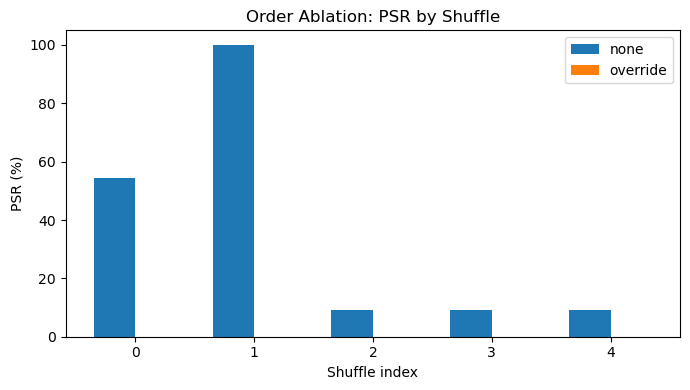

Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/notebooks/results/plots/order_ablation_psr.png


In [8]:

if 'order_summary' in globals() and not order_summary.empty:
    import numpy as np
    plt.figure(figsize=(7,4))
    shufs = sorted(order_summary["shuffle"].dropna().unique())
    width = 0.35
    x_idx = np.arange(len(shufs))
    y_none = [order_summary[(order_summary['defense']=='none') & (order_summary['shuffle']==s)]['PSR'].mean() if not order_summary[(order_summary['defense']=='none') & (order_summary['shuffle']==s)].empty else 0.0 for s in shufs]
    y_over = [order_summary[(order_summary['defense']=='override') & (order_summary['shuffle']==s)]['PSR'].mean() if not order_summary[(order_summary['defense']=='override') & (order_summary['shuffle']==s)].empty else 0.0 for s in shufs]

    plt.bar(x_idx - width/2, [v*100 for v in y_none], width, label='none')
    plt.bar(x_idx + width/2, [v*100 for v in y_over], width, label='override')

    plt.xticks(x_idx, [str(s) for s in shufs])
    plt.xlabel("Shuffle index"); plt.ylabel("PSR (%)"); plt.title("Order Ablation: PSR by Shuffle")
    plt.legend(); plt.tight_layout()
    out = OUTDIR / "order_ablation_psr.png"
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)
else:
    print("[WARN] No order ablation data to plot.")
